In [ ]:
# Before running , if it is windows type ctrl+shift+i, paste following text in console.

#function ClickConnect(){
#console.log("Working"); 
#document.querySelector("colab-toolbar-button#connect").click() 
#}
#setInterval(ClickConnect,60000)

# so that, it will not time-out the google colab

In [ ]:
#!pip3 install --upgrade tensorflow-gpu

In [ ]:
#!pip install tensorflow-gpu==1.15

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 38kB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=dfd126dd7eeb631d5243f474dcc3758adbf9cd8dd4a6e71e5676f2ca27c93090
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [3]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)

In [6]:
train_dir = '/gdrive/MyDrive/Capstone/train2'

In [7]:
#Define some parameters
img_size = 224
img_depth = 3  

Function to normalize image according to Model being used

In [8]:
def normalize_data(img):
    
    #Normalize for VGG
    return tf.keras.applications.vgg16.preprocess_input(img)

Define ImageDataGenerator and Create Data Generators objects for Training and Test

In [9]:
#Read the dataset
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range =(2,2),
    channel_shift_range=50.0,
    fill_mode="nearest",
    horizontal_flip=True,
    rescale=1./255,
    preprocessing_function=normalize_data,
    validation_split=0.25,
)


train_generator = data_generator.flow_from_directory(train_dir, target_size=(img_size, img_size), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="training")

validation_generator = data_generator.flow_from_directory(train_dir, target_size=(img_size, img_size), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="validation")

Found 10136 images belonging to 3 classes.
Found 3376 images belonging to 3 classes.


In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


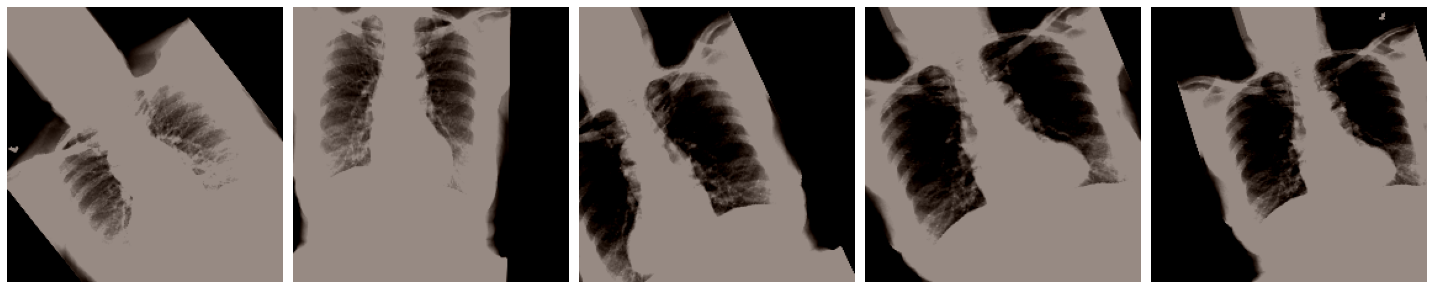

In [11]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Load pre-trained model

In [12]:
tf.keras.backend.clear_session()
model = tf.keras.applications.vgg16.VGG16(include_top=False, #Do not include classification layer for imagenet
                                          input_shape=(img_size,img_size, img_depth),
                                          weights='imagenet')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [13]:
#model.summary()

### Add FC layer for new classes

In [14]:
# Set pretrained model layers to non-trainable
for layer in model.layers:
  layer.trainable = False

In [15]:
len(model.layers)

19

In [16]:
for layer in model.layers[16:]:
  layer.trainable = True

In [17]:
from tensorflow.keras import regularizers

x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)

x= tf.keras.layers.Dense(1024,
                         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                         bias_regularizer=regularizers.l1_l2(l1=1e-4),
                         activity_regularizer=regularizers.l2(1e-5),
                         activation='relu')(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.50)(x)

x= tf.keras.layers.Dense(256,
                         kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                         bias_regularizer=regularizers.l1_l2(l1=1e-4),
                         activity_regularizer=regularizers.l2(1e-5),
                         activation='relu')(x)
                         
x = tf.keras.layers.BatchNormalization()(x)
#Add output layer
prediction= tf.keras.layers.Dense(3, activation='softmax')(x)

### Building final model for Classification

In [18]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [19]:
#Compile the model
nadam = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
final_model.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
#How does our overall model looks
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Train the model

In [21]:
reduce_ = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto')

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')

model_checkpoint=tf.keras.callbacks.ModelCheckpoint('pneumonia_vgg16.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_acc', 
                                                    mode='max', 
                                                    verbose=1)

In [22]:
history = final_model.fit(train_generator, 
                          epochs=70,
                          steps_per_epoch= 10136//64,
                          validation_data=validation_generator,
                          validation_steps = 3376//64, 
                          callbacks=[model_checkpoint, reduce_, early])

Epoch 1/70
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 52/158 [========>.....................] - ETA: 29:24 - loss: 1.7410 - acc: 0.8961
Epoch 00001: val_acc improved from -inf to 0.89613, saving model to pneumonia_vgg16.h5
158/158 [==============================] - 3579s 23s/step - loss: 2.0861 - acc: 0.8714 - val_loss: 1.7410 - val_acc: 0.8961
Epoch 2/70
 52/158 [========>.....................] - ETA: 2:51 - loss: 1.1786 - acc: 0.8711
Epoch 00002: val_acc did not improve from 0.89613
158/158 [==============================] - 357s 2s/step - loss: 1.3006 - acc: 0.9023 - val_loss: 1.1786 - val_acc: 0.8711
Epoch 3/70
 52/158 [========>.....................] - ETA: 2:53 - loss: 0.7742 - acc: 0.9110
Epoch 00003: val_acc improved from 0.89613 to 0.91096, saving model to pneumonia_vgg16.h5
158/158 [==============================] - 348s 2s/step - loss: 0.8598 - acc: 0.9088 - val_loss: 0.7742 - val_acc: 0.9110
Epoch 4/70
 52/158 [========>..

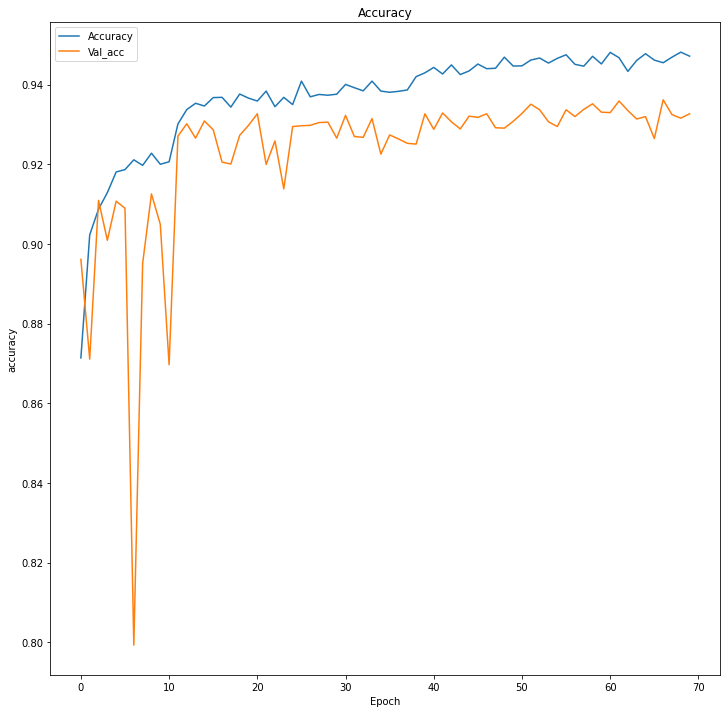

In [23]:
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label = 'Val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

In [24]:
score = final_model.evaluate_generator(validation_generator,steps = 32)                          
print("%s: %.2f%%" % (final_model.metrics_names[1], score[1]*100))

acc: 93.59%


In [42]:
y_test = final_model.predict_generator(validation_generator)

In [44]:
y_test_non_category = [ np.argmax(t) for t in y_test ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, validation_generator.classes)
conf_mat

array([[   0,    3,    2],
       [  14, 1257,  862],
       [  10,  731,  497]])

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test_non_category, validation_generator.classes,target_names=validation_generator.class_indices))

              precision    recall  f1-score   support

    COVID-19       0.00      0.00      0.00         5
      normal       0.63      0.59      0.61      2133
   pneumonia       0.37      0.40      0.38      1238

    accuracy                           0.52      3376
   macro avg       0.33      0.33      0.33      3376
weighted avg       0.53      0.52      0.53      3376



In [47]:
model_json = final_model.to_json()
with open("final_model.json", "w") as json_file:
    json_file.write(model_json)

In [48]:
model.save_weights('pneumonia_vgg16_1.h5')

In [49]:
!cp ./pneumonia_vgg16.h5 '/gdrive/MyDrive/Capstone/Stage1_trail'

In [52]:
 # load json and create model
#json_file = open('final_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = final_model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("pneumonia_vgg16_1.h5")
#print("Loaded model from disk")
 
# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
#score = loaded_model.evaluate(validation_generator, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))